RNA-Seq Differential Gene Expression Analysis Using TPM Normalization and Volcano Plot Visualization

In [1]:
# Import core data handling libraries
import pandas as pd
import numpy as np

# Import statistical functions
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Google Colab file upload utility
from google.colab import files

# Upload a CSV file from the local machine to Colab
uploaded = files.upload()

Saving rnaseq_counts_large.csv to rnaseq_counts_large.csv


In [3]:
# Read the uploaded CSV file into a pandas DataFrame
counts_df = pd.read_csv(list(uploaded.keys())[0])

# Preview the first few rows of the dataset
print(counts_df.head())

      Gene_ID  P001_sen  P002_sen  P003_sen  P004_sen  P005_sen  P006_res  \
0  ENSG000001      1486      1362      1366      1043      1304        90   
1  ENSG000002       930      1284      1446       820       966       138   
2  ENSG000003      1073      1187      1400      1115       813       285   
3  ENSG000004      1041      1145      1364      1139       891       292   
4  ENSG000005      1166      1254      1227      1308       834        82   

   P007_res  P008_res  P009_res  P010_res  Gene_Length (BP)  
0       206        64        94       114              4174  
1       120        58       137       178              4507  
2       185       265       112       188              1860  
3       130       185       212       212              2294  
4       172        54       283       280              2130  


In [4]:
# Display dataset structure and data types
counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Gene_ID           50 non-null     object
 1   P001_sen          50 non-null     int64 
 2   P002_sen          50 non-null     int64 
 3   P003_sen          50 non-null     int64 
 4   P004_sen          50 non-null     int64 
 5   P005_sen          50 non-null     int64 
 6   P006_res          50 non-null     int64 
 7   P007_res          50 non-null     int64 
 8   P008_res          50 non-null     int64 
 9   P009_res          50 non-null     int64 
 10  P010_res          50 non-null     int64 
 11  Gene_Length (BP)  50 non-null     int64 
dtypes: int64(11), object(1)
memory usage: 4.8+ KB


In [5]:
# Show basic statistical summary of numeric columns
counts_df.describe()

,P001_sen,P002_sen,P003_sen,P004_sen,P005_sen,P006_res,P007_res,P008_res,P009_res,P010_res,Gene_Length (BP)
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.00000,50.000000
mean,550.260000,536.420000,537.060000,527.620000,508.960000,536.460000,549.680000,543.14000,556.180000,586.86000,3012.020000
std,325.459788,352.194699,379.620563,341.330523,300.346056,346.802785,373.112799,374.86188,356.796271,401.74436,1161.184538
min,115.000000,64.000000,50.000000,54.000000,77.000000,82.000000,61.000000,54.00000,82.000000,86.00000,1021.000000
25%,347.750000,354.000000,319.750000,337.000000,309.750000,335.250000,341.250000,333.50000,337.250000,326.25000,2085.250000
50%,456.000000,457.000000,424.000000,474.500000,429.000000,448.000000,452.500000,450.50000,479.500000,479.50000,3091.000000
75%,552.000000,545.750000,581.500000,561.250000,573.000000,574.250000,576.000000,583.50000,569.250000,582.25000,4070.250000
max,1486.000000,1365.000000,1446.000000,1308.000000,1304.000000,1463.000000,1491.000000,1471.00000,1439.000000,1498.00000,4772.000000


In [6]:
# Convert gene length from base pairs to kilobases (required for TPM calculation)
gene_length = counts_df['Gene_Length (BP)'] / 1000

# Remove non-count columns to retain only raw read counts
counts = counts_df.drop(['Gene_ID', 'Gene_Length (BP)'], axis=1)

# Print gene length values
print(gene_length)

# Display count matrix
counts

0     4.174
1     4.507
2     1.860
3     2.294
4     2.130
5     2.095
6     4.772
7     4.092
8     2.638
9     3.169
10    1.466
11    2.238
12    1.330
13    2.482
14    3.135
15    4.444
16    4.171
17    3.919
18    4.735
19    1.130
20    2.685
21    4.380
22    1.769
23    3.391
24    2.515
25    4.485
26    3.853
27    3.433
28    2.215
29    1.955
30    3.324
31    2.184
32    1.459
33    4.385
34    1.021
35    3.300
36    1.747
37    3.904
38    4.632
39    1.474
40    2.082
41    3.558
42    4.753
43    3.047
44    4.547
45    3.747
46    1.975
47    2.806
48    1.189
49    4.005
Name: Gene_Length (BP), dtype: float64


,P001_sen,P002_sen,P003_sen,P004_sen,P005_sen,P006_res,P007_res,P008_res,P009_res,P010_res
0,1486,1362,1366,1043,1304,90,206,64,94,114
1,930,1284,1446,820,966,138,120,58,137,178
2,1073,1187,1400,1115,813,285,185,265,112,188
3,1041,1145,1364,1139,891,292,130,185,212,212
4,1166,1254,1227,1308,834,82,172,54,283,280
5,1005,880,1361,1187,801,299,90,77,184,250
6,1189,1365,905,1276,1201,121,61,211,82,97
7,1355,961,1001,1069,1070,296,200,111,265,86
8,1255,1261,1051,1095,1137,148,221,153,263,268
9,852,1016,987,1179,1292,84,242,276,150,224


In [7]:
# Calculate Reads Per Kilobase (RPK)
# Each gene count is divided by its gene length
rpk = counts.div(gene_length, axis=0)

# Display RPK values
rpk

,P001_sen,P002_sen,P003_sen,P004_sen,P005_sen,P006_res,P007_res,P008_res,P009_res,P010_res
0,356.013416,326.305702,327.264015,249.880211,312.410158,21.562051,49.353138,15.333014,22.520364,27.311931
1,206.345684,284.890171,320.834258,181.939206,214.333259,30.619037,26.625250,12.868871,30.397160,39.494120
2,576.881720,638.172043,752.688172,599.462366,437.096774,153.225806,99.462366,142.473118,60.215054,101.075269
3,453.792502,499.128160,594.594595,496.512642,388.404534,127.288579,56.669573,80.645161,92.414996,92.414996
4,547.417840,588.732394,576.056338,614.084507,391.549296,38.497653,80.751174,25.352113,132.863850,131.455399
5,479.713604,420.047733,649.642005,566.587112,382.338902,142.720764,42.959427,36.754177,87.828162,119.331742
6,249.161777,286.043588,189.647946,267.393127,251.676446,25.356245,12.782900,44.216262,17.183571,20.326907
7,331.133920,234.848485,244.623656,261.241447,261.485826,72.336266,48.875855,27.126100,64.760508,21.016618
8,475.739196,478.013647,398.407885,415.087187,431.008340,56.103108,83.775588,57.998484,99.696740,101.592115
9,268.854528,320.605869,311.454718,372.041654,407.699590,26.506784,76.364784,87.093720,47.333544,70.684759


In [8]:
# Calculate scaling factor for TPM normalization
# Sum RPK values per sample and divide by 1,000,000
scaling_factor = rpk.sum() / 1_000_000

# Display scaling factors
scaling_factor

,0
P001_sen,0.010571
P002_sen,0.010095
P003_sen,0.010201
P004_sen,0.010135
P005_sen,0.009561
P006_res,0.011078
P007_res,0.011151
P008_res,0.011441
P009_res,0.011755
P010_res,0.012274


In [9]:
# Calculate Transcripts Per Million (TPM)
# Divide RPK by the scaling factor for each sample
tpm = rpk.div(scaling_factor, axis=1)

# Preview TPM data
print('TPM Data Preview:')
print(tpm.head())

TPM Data Preview:
       P001_sen      P002_sen      P003_sen      P004_sen      P005_sen  \
0  33678.438215  32323.257736  32081.284533  24656.114869  32674.966487   
1  19520.051959  28220.709485  31450.983399  17952.257762  22417.107399   
2  54572.312404  63216.178270  73785.085683  59149.993897  45715.934892   
3  42928.221364  49442.740581  58287.368844  48991.765640  40623.215307   
4  51785.065018  58318.775326  56470.086602  60592.786018  40952.125866   

       P006_res     P007_res      P008_res      P009_res      P010_res  
0   1946.328777  4425.916229   1340.230939   1915.752683   2225.265910  
1   2763.870354  2387.712879   1124.844646   2585.812573   3217.821524  
2  13831.142474  8919.637365  12453.316900   5122.348378   8235.204974  
3  11489.882226  5082.043203   7049.047302   7861.519229   7529.600867  
4   3475.044642  7241.645440   2215.982194  11302.405010  10710.455375  


In [10]:
# Define sample groups
# sen = sensitive samples
# res = resistant samples
sen_cols = ['P001_sen','P002_sen','P003_sen','P004_sen','P005_sen']
res_cols = ['P006_res','P007_res','P008_res','P009_res','P010_res']

In [11]:
# Calculate mean TPM for each gene in each condition
sen_mean = tpm[sen_cols].mean(axis=1)
res_mean = tpm[res_cols].mean(axis=1)

In [12]:
# Print mean expression values
print('sen_mean:', sen_mean)
print('res_mean:', res_mean)

sen_mean: 0     31082.812368
1     23912.222001
2     59287.901029
3     48054.662347
4     53623.767766
5     49313.609213
6     24640.658864
7     26338.926183
8     43489.495323
9     33414.951099
10    10928.840390
11     7933.379378
12    10715.218665
13     8153.519407
14     6242.817346
15     5484.228022
16     3109.454229
17     4323.965312
18     3261.411838
19    13717.921787
20    16550.445536
21    11570.220644
22    26542.911454
23    12901.524729
24    16256.788804
25     9631.533869
26    11764.677703
27    13966.657669
28    19675.727121
29    23265.111077
30    12028.157546
31    21305.532036
32    31058.766486
33    11681.117029
34    41409.128995
35    13265.752551
36    22952.157268
37    11085.624005
38     9741.430538
39    31683.893415
40    22340.059880
41    12052.329648
42     9340.492267
43    14531.558891
44     9586.853894
45    11603.663991
46    21046.651819
47    16578.367606
48    36759.104383
49    10793.996582
dtype: float64
res_mean: 0      2370.698

In [13]:
# Calculate log2 fold change with pseudocount to avoid log(0)
log2_fc = np.log2((res_mean + 1) / (sen_mean + 1))

# Display log2 fold change values
print('log2_fc:', log2_fc)

log2_fc: 0    -3.712171
1    -3.306512
2    -2.609724
3    -2.622528
4    -2.939513
5    -2.730696
6    -3.563264
7    -2.682848
8    -2.659804
9    -2.648637
10    2.784437
11    2.420170
12    2.935041
13    2.388731
14    2.440882
15    2.273026
16    2.997256
17    2.646358
18    2.779576
19    2.624566
20   -0.042335
21   -0.248753
22   -0.179212
23    0.019163
24   -0.215216
25   -0.257068
26   -0.133211
27   -0.425782
28    0.033956
29   -0.421006
30    0.012853
31   -0.197850
32   -0.162168
33   -0.562912
34   -0.090703
35   -0.124753
36   -0.100812
37   -0.095939
38   -0.422782
39   -0.214115
40   -0.195936
41   -0.077744
42   -0.014622
43   -0.056651
44   -0.225910
45   -0.101126
46    0.011989
47   -0.344331
48    0.058987
49   -0.028087
dtype: float64


In [14]:
# Perform Welch’s t-test for each gene between sen and res groups
p_values = []

for gene in tpm.index:
    t_stat, p_val = stats.ttest_ind(
        tpm.loc[gene, sen_cols],
        tpm.loc[gene, res_cols],
        equal_var=False  # Welch’s t-test
    )
    p_values.append(p_val)

In [15]:
# Create a DEG DataFrame with fold change and p-values
deg_df = pd.DataFrame({
    'log2_fc': log2_fc,
    'p_value': p_values
}, index=tpm.index)

print('DEG Data Preview:')
print(deg_df.head())

DEG Data Preview:
    log2_fc   p_value
0 -3.712171  0.000018
1 -3.306512  0.000992
2 -2.609724  0.000185
3 -2.622528  0.000069
4 -2.939513  0.000020


In [16]:
# Adjust p-values using Benjamini–Hochberg FDR correction
deg_df['padj'] = multipletests(deg_df['p_value'], method='fdr_bh')[1]

print('DEG Data Preview:')
print(deg_df.head())

DEG Data Preview:
    log2_fc   p_value      padj
0 -3.712171  0.000018  0.000117
1 -3.306512  0.000992  0.002480
2 -2.609724  0.000185  0.000677
3 -2.622528  0.000069  0.000312
4 -2.939513  0.000020  0.000117


In [17]:
# Set thresholds for significance
log2fc_cutoff = 1
p_cutoff = 0.05

In [18]:
# Calculate -log10(adjusted p-value) for volcano plot
deg_df['Neg_log_padj'] = -np.log10(deg_df['padj'])

print('DEG Data Preview:')
print(deg_df.head())

DEG Data Preview:
    log2_fc   p_value      padj  Neg_log_padj
0 -3.712171  0.000018  0.000117      3.932100
1 -3.306512  0.000992  0.002480      2.605535
2 -2.609724  0.000185  0.000677      3.169378
3 -2.622528  0.000069  0.000312      3.505789
4 -2.939513  0.000020  0.000117      3.932100


In [19]:
# Create final DEG DataFrame with gene IDs included
final_deg_df = pd.DataFrame({
    'Gene_ID': counts_df['Gene_ID'],
    'log2_fc': deg_df['log2_fc'],
    'padj': deg_df['padj'],
    'Neg_log_padj': deg_df['Neg_log_padj']
})

print('Final DEG Data Preview:')
print(final_deg_df.head())

Final DEG Data Preview:
      Gene_ID   log2_fc      padj  Neg_log_padj
0  ENSG000001 -3.712171  0.000117      3.932100
1  ENSG000002 -3.306512  0.002480      2.605535
2  ENSG000003 -2.609724  0.000677      3.169378
3  ENSG000004 -2.622528  0.000312      3.505789
4  ENSG000005 -2.939513  0.000117      3.932100


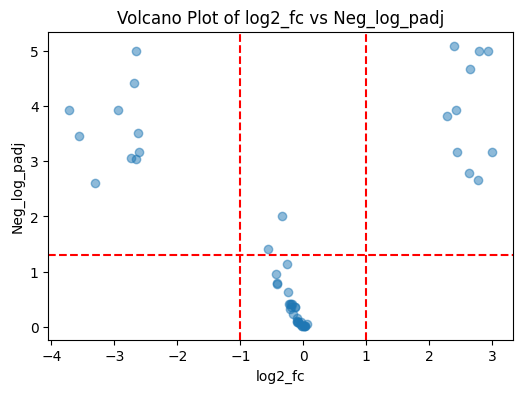

In [20]:
# Generate volcano plot
plt.figure(figsize=(6,4))
plt.scatter(final_deg_df['log2_fc'], final_deg_df['Neg_log_padj'], alpha=0.5)

# Add cutoff lines
plt.axvline(x=log2fc_cutoff, color='red', linestyle='--')
plt.axvline(x=-log2fc_cutoff, color='red', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')

# Add plot labels
plt.title('Volcano Plot of log2_fc vs Neg_log_padj')
plt.xlabel('log2_fc')
plt.ylabel('Neg_log_padj')

plt.show()

In [21]:
# Function to classify gene regulation status
def classify_regulation(row):
    if row['log2_fc'] >= log2fc_cutoff and row['padj'] < p_cutoff:
        return 'Up'
    elif row['log2_fc'] <= -log2fc_cutoff and row['padj'] < p_cutoff:
        return 'Down'
    else:
        return 'No_Regulation'

In [22]:
# Apply classification to each gene
final_deg_df['Regulation'] = final_deg_df.apply(classify_regulation, axis=1)

print('Final DEG Data Preview:')
print(final_deg_df.to_string())

Final DEG Data Preview:
       Gene_ID   log2_fc      padj  Neg_log_padj     Regulation
0   ENSG000001 -3.712171  0.000117      3.932100           Down
1   ENSG000002 -3.306512  0.002480      2.605535           Down
2   ENSG000003 -2.609724  0.000677      3.169378           Down
3   ENSG000004 -2.622528  0.000312      3.505789           Down
4   ENSG000005 -2.939513  0.000117      3.932100           Down
5   ENSG000006 -2.730696  0.000876      3.057352           Down
6   ENSG000007 -3.563264  0.000349      3.457137           Down
7   ENSG000008 -2.682848  0.000039      4.410337           Down
8   ENSG000009 -2.659804  0.000010      4.988043           Down
9   ENSG000010 -2.648637  0.000919      3.036788           Down
10  ENSG000011  2.784437  0.000010      4.988043             Up
11  ENSG000012  2.420170  0.000117      3.932100             Up
12  ENSG000013  2.935041  0.000010      4.988043             Up
13  ENSG000014  2.388731  0.000008      5.089974             Up
14  ENSG000015  

In [23]:
# Extract significantly upregulated genes
up_genes=final_deg_df[final_deg_df['Regulation']=='Up'].sort_values(by='padj', ascending=False)

# Extract significantly downregulated genes
down_genes=final_deg_df[final_deg_df['Regulation']=='Down'].sort_values(by='padj', ascending=False)

In [24]:
# Display top genes
print('Upregulated Genes:')
print(up_genes.head(10))

Upregulated Genes:
       Gene_ID   log2_fc      padj  Neg_log_padj Regulation
18  ENSG000019  2.779576  0.002165      2.664547         Up
19  ENSG000020  2.624566  0.001642      2.784576         Up
16  ENSG000017  2.997256  0.000678      3.168966         Up
14  ENSG000015  2.440882  0.000677      3.169378         Up
15  ENSG000016  2.273026  0.000156      3.808161         Up
11  ENSG000012  2.420170  0.000117      3.932100         Up
17  ENSG000018  2.646358  0.000022      4.663813         Up
10  ENSG000011  2.784437  0.000010      4.988043         Up
12  ENSG000013  2.935041  0.000010      4.988043         Up
13  ENSG000014  2.388731  0.000008      5.089974         Up


In [25]:
# Display top genes
print('Downregulated Genes:')
print(down_genes.head(10))

Downregulated Genes:
      Gene_ID   log2_fc      padj  Neg_log_padj Regulation
1  ENSG000002 -3.306512  0.002480      2.605535       Down
9  ENSG000010 -2.648637  0.000919      3.036788       Down
5  ENSG000006 -2.730696  0.000876      3.057352       Down
2  ENSG000003 -2.609724  0.000677      3.169378       Down
6  ENSG000007 -3.563264  0.000349      3.457137       Down
3  ENSG000004 -2.622528  0.000312      3.505789       Down
0  ENSG000001 -3.712171  0.000117      3.932100       Down
4  ENSG000005 -2.939513  0.000117      3.932100       Down
7  ENSG000008 -2.682848  0.000039      4.410337       Down
8  ENSG000009 -2.659804  0.000010      4.988043       Down
